In [99]:
import numpy as np
from numpy.random import default_rng
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from scipy import stats
from scipy.stats import betabinom
import matplotlib.pyplot as plt
from jax.scipy.special import expit
from scipy.stats import beta
import arviz as az
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform, OrderedTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
import numpyro.optim as optim

from jax import random, lax

### Look at identifying out of stock periods..maybe using kernel since adjacent periods likely to have same stock status 

#### Generate some data, but decided not to use this for now

In [6]:
# Size of data to simulate
num_S = 5 # Number of stores
num_D = 3 # Number of stores
H = 10 # Number of hours that is store is open for in one day
num_I = 5 # Number of (possibly) substitute items

In [7]:
# Indices
S = np.arange(num_S) # Set of stores
D = np.arange(num_D) # Set of days
T = np.arange(num_D*H*60) # Set of minutes during the period
C = np.arange(len(T)/10) # Set of customer visits to stores
I = np.arange(num_I) # Set of (possibly) substitute items

In [3]:
# Random number generator seed for reproducability
rng = default_rng(seed=14032022)

(5, 180, 5)


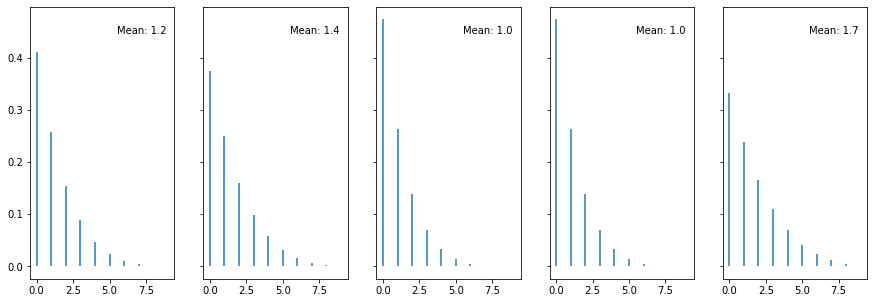

In [9]:
# Generate customer demand

# Each store has a different customer profile (in terms of the demand for the items in I)
# # So each customer is expected to buy n*p units and b ~ Beta(a, b).  n is the maximum possible demand for the item from one customer in one visit
n = np.repeat(10,num_S) # Not varying by store, but obviously could
a = rng.integers(low=1, high=2, size=num_S)
b = rng.integers(low=5, high=10, size=num_S)

# Plot pdf
fig, ax = plt.subplots(1,5, figsize=(15,5), sharey=True)
d=np.empty([num_S,len(C),num_I])
print(d.shape)
for s in range(num_S):
    x = np.arange(n[s])
    rv = betabinom(n[s], a[s], b[s])
    ax[s].vlines(x, 0, rv.pmf(x))
    ax[s].text(0.6, 0.9, f'Mean: {rv.mean():.2}', transform = ax[s].transAxes)
    d[s,...] = rv.rvs(size=[len(C),num_I], random_state=rng)

#d = betabinom(n, a, b).rvs(size=[num_S, len(C),num_I], random_state=rng)


t = np.sort(rng.integers(low=0, high=len(T)+1, size=len(C)))


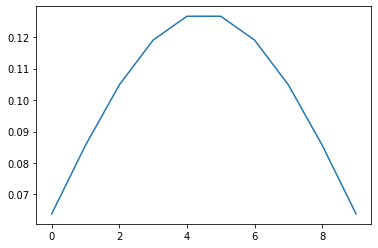

In [10]:
h = 0.5 + 0.5*np.sin(np.pi*np.arange(H)/(H-1))
plt.plot(h/np.sum(h))

In [11]:
rng.dirichlet(alpha=np.repeat(0.5,num_I), size=(10))

array([[2.91224811e-01, 1.09821807e-02, 6.88333098e-03, 5.91819792e-02,
        6.31727698e-01],
       [2.29037985e-01, 4.64963420e-02, 5.59180402e-01, 6.17415569e-02,
        1.03543714e-01],
       [3.76421037e-01, 7.69098130e-02, 4.95894069e-01, 2.88921109e-02,
        2.18829698e-02],
       [5.08883617e-02, 2.23307985e-02, 8.12378047e-01, 1.12588655e-01,
        1.81413743e-03],
       [2.01623194e-01, 3.21794015e-01, 1.31612650e-01, 3.44902517e-01,
        6.76245484e-05],
       [5.85978010e-02, 1.30001199e-01, 2.44400704e-03, 6.88733238e-01,
        1.20223755e-01],
       [1.10887655e-01, 2.35391520e-02, 6.05979849e-01, 1.32333100e-01,
        1.27260244e-01],
       [2.45472413e-02, 2.39099359e-01, 2.03173401e-01, 3.50086355e-01,
        1.83093644e-01],
       [1.35353203e-01, 3.75988415e-01, 2.28600951e-01, 2.09454349e-01,
        5.06030820e-02],
       [8.92229073e-02, 7.48523350e-01, 5.34072263e-02, 3.20108757e-02,
        7.68356409e-02]])

#### Using this data instead

In [62]:
# Simple - one item only

N= 100
p = 0.5
t = np.arange(N)
td = np.subtract.outer(t, t)
d = rng.binomial(1,p,N)
s = np.repeat([0,1,0,1], N/4)
x = d * s
i = jnp.where(x>0,1,np.nan) # in-stock indicator

In [8]:
def make_cov(td, etasq, rhosq, sigmasq):
    d2 = jnp.square(td/jnp.max(td))
    #d2=jnp.array(td)
    return etasq * jnp.exp(-1*rhosq*d2) + jnp.eye(td.shape[0]) * sigmasq

def model(td, x):
    n = x.shape[0]

    # Demand model...for now each customer has same average probability of buying
    alpha_demand = numpyro.sample('alpha_demand', dist.Normal(0,1))
    logit_demand = alpha_demand
    p_demand = expit(logit_demand)

    # Stockouts
    #Get logit(stockout) at each time....logits(stockout)
    alpha_stockout = numpyro.sample('alpha_stockout', dist.Normal(0,1))
    etasq = numpyro.sample('eta_squared', dist.Exponential(2))
    rhosq = numpyro.sample('rho_squared', dist.Exponential(0.5))
    sigmasq = 0.01
    cov = make_cov(td, etasq, rhosq, sigmasq)
    logit_stockout = alpha_stockout + numpyro.sample('logit_astockout', dist.MultivariateNormal(loc=0, covariance_matrix=cov))
    p_stockout = expit(logit_stockout)


    with numpyro.plate('obs', n):

        # demand
        #d = numpyro.sample('d', dist.BernoulliProbs(p_demand), infer={"enumerate": "parallel"})

        # stockout
        #s = numpyro.sample('s', dist.BernoulliProbs(p_stockout), infer={"enumerate": "parallel"})

        # observe sales
        sales = numpyro.sample('sales', dist.BernoulliProbs(p_demand*p_stockout), obs=x)
    

m1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m1.run(random.PRNGKey(0), td=td, x=x)
m1.print_summary()




/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:34<00:00, 28.63it/s, 15 steps of size 1.47e-01. acc. prob=0.90]



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha_demand     -0.01      0.75     -0.11     -1.10      1.23    181.76      1.02
     alpha_stockout      0.03      0.79     -0.04     -1.14      1.38    483.30      1.01
        eta_squared      0.53      0.57      0.34      0.00      1.30    101.61      1.02
 logit_astockout[0]     -0.13      0.80     -0.04     -1.25      1.39     17.51      1.16
 logit_astockout[1]     -0.12      0.80     -0.04     -1.19      1.41     17.29      1.16
 logit_astockout[2]     -0.12      0.79     -0.05     -1.10      1.52     16.57      1.17
 logit_astockout[3]     -0.11      0.79     -0.03     -1.16      1.45     17.04      1.16
 logit_astockout[4]     -0.11      0.79     -0.03     -1.20      1.41     16.69      1.17
 logit_astockout[5]     -0.10      0.78     -0.02     -1.27      1.30     16.35      1.17
 logit_astockout[6]     -0.09      0.77     -0.02     -1.06      1.52     16.22      1.17
 logit_as

In [13]:
post = m1.get_samples()

In [14]:
post.keys()

dict_keys(['alpha_demand', 'alpha_stockout', 'kernel_length', 'kernel_noise', 'kernel_var', 'logit_astockout'])

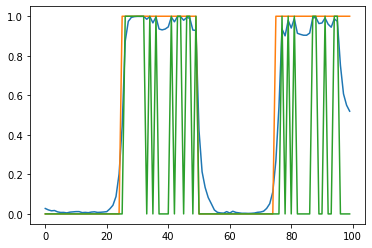

In [15]:
pstock = expit(post['logit_astockout'])
pstock_mean = pstock.mean(axis=0)
plt.plot(pstock_mean)
plt.plot(s)
plt.plot(x)

In [12]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(t, x):
    n = x.shape[0]

    # Demand model...for now each customer has same average probability of buying
    alpha_demand = numpyro.sample('alpha_demand', dist.Normal(0,1))
    logit_demand = alpha_demand
    p_demand = expit(logit_demand)

    # Stockouts
    #Get logit(stockout) at each time....logits(stockout)
    alpha_stockout = numpyro.sample('alpha_stockout', dist.Normal(0,1))

    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    cov = kernel(t, t, var, length, noise)
    logit_stockout = alpha_stockout + numpyro.sample('logit_astockout', dist.MultivariateNormal(loc=0, covariance_matrix=cov))
    p_stockout = expit(logit_stockout)


    with numpyro.plate('obs', n):

        # demand
        #d = numpyro.sample('d', dist.BernoulliProbs(p_demand), infer={"enumerate": "parallel"})

        # stockout
        #s = numpyro.sample('s', dist.BernoulliProbs(p_stockout), infer={"enumerate": "parallel"})

        # observe sales
        sales = numpyro.sample('sales', dist.BernoulliProbs(p_demand*p_stockout), obs=x)
    

m1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m1.run(random.PRNGKey(0), t=t, x=x)
m1.print_summary()


/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [05:37<00:00,  2.97it/s, 971 steps of size 9.62e-03. acc. prob=0.72]



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
       alpha_demand     -0.02      0.37     -0.03     -0.57      0.52     62.48      1.06
     alpha_stockout     -0.04      0.95     -0.05     -1.56      1.48    403.56      1.01
      kernel_length     12.40      5.72     12.05      2.92     20.08      5.05      1.61
       kernel_noise    478.47   1622.91      5.73      0.01   1245.12     13.11      1.42
         kernel_var 146818.31 397498.28  22460.99     30.56 334400.50     23.84      1.15
 logit_astockout[0]   -222.56    312.87    -88.99   -713.20     27.05     16.93      1.25
 logit_astockout[1]   -232.20    314.54   -102.11   -712.89     18.04     16.14      1.27
 logit_astockout[2]   -241.37    316.76   -112.89   -687.02     28.63     15.60      1.28
 logit_astockout[3]   -247.60    320.06   -118.17   -696.71     25.31     14.90      1.29
 logit_astockout[4]   -252.92    322.10   -126.96   -691.95     12.97     14.31      1.30
 logit_as

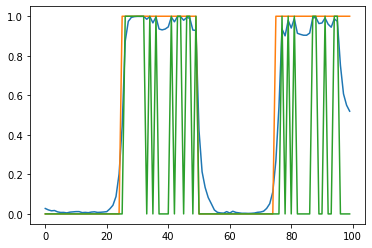

In [16]:
post = m1.get_samples()
pstock = expit(post['logit_astockout'])
pstock_mean = pstock.mean(axis=0)
plt.plot(pstock_mean)
plt.plot(s)
plt.plot(x)

In [17]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(t, x):
    n = x.shape[0]

    # Demand model...for now each customer has same average probability of buying
    alpha_demand = numpyro.sample('alpha_demand', dist.Normal(0,1))
    logit_demand = alpha_demand
    p_demand = expit(logit_demand)

    # Stockouts
    #Get logit(stockout) at each time....logits(stockout)
    alpha_stockout = numpyro.sample('alpha_stockout', dist.Normal(0,1))

    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    cov = kernel(t, t, var, length, noise)
    L_cov = jnp.linalg.cholesky(cov)
    z = numpyro.sample("z", dist.Normal(0, 1).expand([n]))
    z_cov = (L_cov @ z[..., None])[..., 0]
    logit_stockout = alpha_stockout + z_cov#numpyro.sample('logit_astockout', dist.MultivariateNormal(loc=0, covariance_matrix=cov))
    p_stockout = expit(logit_stockout)


    with numpyro.plate('obs', n):

        # demand
        #d = numpyro.sample('d', dist.BernoulliProbs(p_demand), infer={"enumerate": "parallel"})

        # stockout
        #s = numpyro.sample('s', dist.BernoulliProbs(p_stockout), infer={"enumerate": "parallel"})

        # observe sales
        sales = numpyro.sample('sales', dist.BernoulliProbs(p_demand*p_stockout), obs=x)
    

m1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
m1.run(random.PRNGKey(0), t=t, x=x)
m1.print_summary()


/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/numpyro/infer/mcmc.py:274: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [10:55<00:00,  1.53it/s, 1023 steps of size 3.39e-05. acc. prob=0.99]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha_demand      0.46      0.98      0.24     -0.67      2.04      2.01     27.77
  alpha_stockout     -0.92      0.94     -1.04     -2.16      0.48      2.02     19.22
   kernel_length      7.42      3.82      8.04      2.24     12.36      2.01     31.11
    kernel_noise    339.21    587.67      0.00      0.00   1358.34      2.00    484.37
      kernel_var 28285466.00 49003680.00    674.07      5.98 113140808.00      2.00    392.94
            z[0]     -0.89      0.41     -0.97     -1.34     -0.24      2.02     13.02
            z[1]     -0.66      0.41     -0.62     -1.31     -0.20      2.03     12.45
            z[2]      0.26      0.53      0.16     -0.49      0.98      2.04      9.34
            z[3]     -0.34      0.45     -0.21     -0.95      0.18      2.04     13.16
            z[4]     -0.05      0.19      0.08     -0.35      0.13      2.17      5.43
            z[5]     -0.70      0.6

In [18]:
post = m1.get_samples()
pstock = expit(post['logit_astockout'])
pstock_mean = pstock.mean(axis=0)
plt.plot(pstock_mean)
plt.plot(s)
plt.plot(x)

KeyError: 'logit_astockout'

In [41]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    return k


def model(t, x):
    n = x.shape[0]

    # Demand model...for now each customer has same average probability of buying
    alpha_demand = numpyro.sample('alpha_demand', dist.Normal(0,1))
    logit_demand = alpha_demand
    p_demand = expit(logit_demand)
    

    # Stockouts
    #Get logit(stockout) at each time....logits(stockout)
    alpha_stockout = numpyro.sample('alpha_stockout', dist.Normal(0,1))

    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    #noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    cov = kernel(t, t, var, length)
    L_cov = jnp.linalg.cholesky(cov)
    z = numpyro.sample("z", dist.Normal(0, 1).expand([n]))
    z_cov = (L_cov @ z[..., None])[..., 0]
    logit_stockout = numpyro.deterministic('logit_stockout', alpha_stockout + z_cov)#numpyro.sample('logit_astockout', dist.MultivariateNormal(loc=0, covariance_matrix=cov))
    p_stockout = expit(logit_stockout)


    with numpyro.plate('obs', n):

        # demand
        #d = numpyro.sample('d', dist.BernoulliProbs(p_demand), infer={"enumerate": "parallel"})

        # stockout
        #s = numpyro.sample('s', dist.BernoulliProbs(p_stockout), infer={"enumerate": "parallel"})

        # observe sales
        logit_sales = logit_demand + logit_stockout
        sales = numpyro.sample('sales', dist.BernoulliLogits(logit_sales), obs=x)
    

m1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m1.run(random.PRNGKey(0), t=t, x=x)
m1.print_summary()

sample: 100%|██████████| 1000/1000 [04:52<00:00,  3.42it/s, 1023 steps of size 3.98e-09. acc. prob=0.81]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha_demand     -0.21      0.00     -0.21     -0.21     -0.21      3.78      1.92
  alpha_stockout     -0.70      0.00     -0.70     -0.70     -0.70      0.50      1.00
   kernel_length      2.14      0.00      2.14      2.14      2.14      1.85      1.00
      kernel_var      0.00      0.00      0.00      0.00      0.00      0.50       nan
            z[0]      0.26      0.00      0.26      0.26      0.26      0.50      1.00
            z[1]     -0.85      0.00     -0.85     -0.85     -0.85      0.50      1.00
            z[2]     -0.15      0.00     -0.15     -0.15     -0.15      3.81      1.28
            z[3]      0.68      0.00      0.68      0.68      0.68      0.50      1.00
            z[4]      0.84      0.00      0.84      0.84      0.84      0.50      1.00
            z[5]      0.16      0.00      0.16      0.16      0.16      7.43      1.23
            z[6]      1.53      0.00      

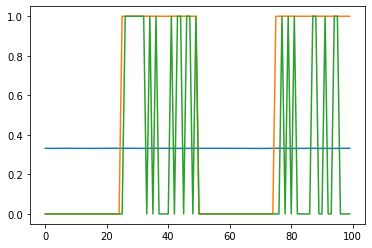

In [42]:
post = m1.get_samples()
pstock = expit(post['logit_stockout'])
pstock_mean = pstock.mean(axis=0)
plt.plot(pstock_mean)
plt.plot(s)
plt.plot(x)


sample: 100%|██████████| 1000/1000 [08:28<00:00,  1.96it/s, 1023 steps of size 3.89e-06. acc. prob=0.86]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha_demand      1.60      0.00      1.60      1.60      1.60      3.59      1.51
  alpha_stockout      1.93      0.00      1.93      1.93      1.93      0.50      1.00
   kernel_length      2.45      0.00      2.45      2.45      2.45      4.70      1.00
      kernel_var      0.51      0.00      0.51      0.51      0.51      2.31      1.36
            z[0]     -0.57      0.00     -0.57     -0.57     -0.57      3.81      1.65
            z[1]      0.11      0.00      0.11      0.11      0.11      5.82      1.36
            z[2]      0.69      0.00      0.69      0.69      0.69      4.91      1.00
            z[3]      0.13      0.00      0.13      0.13      0.13     15.62      1.01
            z[4]     -0.51      0.00     -0.51     -0.51     -0.51      4.23      1.49
            z[5]     -0.72      0.00     -0.72     -0.72     -0.72      3.29      2.03
            z[6]      1.17      0.00      

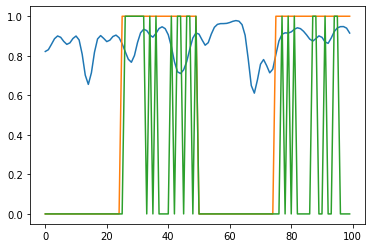

In [44]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    return k


def model(t, x):
    n = x.shape[0]
    #t_std = (t - jnp.mean(t) )/ jnp.std(t)

    # Demand model...for now each customer has same average probability of buying
    alpha_demand = numpyro.sample('alpha_demand', dist.Normal(0,1))
    logit_demand = alpha_demand
    p_demand = expit(logit_demand)

    # Stockouts
    #Get logit(stockout) at each time....logits(stockout)
    alpha_stockout = numpyro.sample('alpha_stockout', dist.Normal(0,1))

    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    #noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    cov = kernel(t, t, var, length)
    #print(cov)
    L_cov = jnp.linalg.cholesky(cov)
    z = numpyro.sample("z", dist.Normal(0, 1).expand([n]))
    z_cov = (L_cov @ z[..., None])[..., 0]
    
    logit_stockout = numpyro.deterministic('logit_stockout', alpha_stockout + z_cov)#numpyro.sample('logit_astockout', dist.MultivariateNormal(loc=0, covariance_matrix=cov))
    p_stockout = expit(logit_stockout)


    with numpyro.plate('obs', n):

        # demand
        #d = numpyro.sample('d', dist.BernoulliProbs(p_demand), infer={"enumerate": "parallel"})

        # stockout
        #s = numpyro.sample('s', dist.BernoulliProbs(p_stockout), infer={"enumerate": "parallel"})

        # observe sales
        #logit_sales = logit_demand + logit_stockout + sigma_sales
        sales = numpyro.sample('sales', dist.BernoulliProbs(p_demand*p_stockout), obs=x)
    

m1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m1.run(random.PRNGKey(0), t=t, x=x)
m1.print_summary()

post = m1.get_samples()
pstock = expit(post['logit_stockout'])
pstock_mean = pstock.mean(axis=0)
plt.plot(pstock_mean)
plt.plot(s)
plt.plot(x)

sample: 100%|██████████| 1000/1000 [00:04<00:00, 226.10it/s, 15 steps of size 3.83e-01. acc. prob=0.87]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha_demand      0.30      0.47      0.26     -0.42      1.09    564.04      1.00
          z[0]     -0.87      0.85     -0.88     -2.37      0.45    574.60      1.00
          z[1]     -0.69      0.93     -0.67     -2.28      0.70   1224.67      1.00
          z[2]     -0.56      0.85     -0.54     -1.96      0.71    748.39      1.00
          z[3]     -0.49      0.90     -0.47     -1.81      1.06   1270.77      1.00
          z[4]     -0.45      0.94     -0.47     -1.87      1.07   1383.72      1.00
          z[5]     -0.43      1.05     -0.38     -2.08      1.27   1463.58      1.00
          z[6]     -0.41      0.96     -0.44     -2.02      1.08    703.87      1.00
          z[7]     -0.40      1.01     -0.38     -1.95      1.33    873.97      1.00
          z[8]     -0.45      0.97     -0.40     -1.90      1.05    880.91      1.00
          z[9]     -0.36      0.93     -0.34     -1.98      1.07

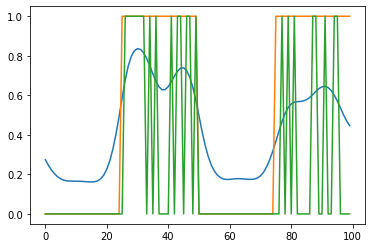

In [61]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k



def model(t, x):
    n = x.shape[0]
    #t_std = (t - jnp.mean(t) )/ jnp.std(t)

    # Demand model...for now each customer has same average probability of buying
    alpha_demand = numpyro.sample('alpha_demand', dist.Normal(0,1))
    logit_demand = alpha_demand
    p_demand = expit(logit_demand)

    # Stockouts
    #Get logit(stockout) at each time....logits(stockout)
    alpha_stockout = 0#numpyro.sample('alpha_stockout', dist.Normal(0,1))

    # set uninformative log-normal priors on our three kernel hyperparameters
    #var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    #noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    #length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    cov = kernel(t, t, 2, 5, 0)
    #print(cov)
    L_cov = jnp.linalg.cholesky(cov)
    z = numpyro.sample("z", dist.Normal(0, 1).expand([n]))
    z_cov = (L_cov @ z[..., None])[..., 0]
    
    logit_stockout = numpyro.deterministic('logit_stockout', alpha_stockout + z_cov)#numpyro.sample('logit_astockout', dist.MultivariateNormal(loc=0, covariance_matrix=cov))
    p_stockout = expit(logit_stockout)


    with numpyro.plate('obs', n):

        # demand
        #d = numpyro.sample('d', dist.BernoulliProbs(p_demand), infer={"enumerate": "parallel"})

        # stockout
        #s = numpyro.sample('s', dist.BernoulliProbs(p_stockout), infer={"enumerate": "parallel"})

        # observe sales
        #logit_sales = logit_demand + logit_stockout + sigma_sales
        sales = numpyro.sample('sales', dist.BernoulliProbs(p_demand*p_stockout), obs=x)
    

m1 = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m1.run(random.PRNGKey(0), t=t, x=x)
m1.print_summary()

post = m1.get_samples()
pstock = expit(post['logit_stockout'])
pstock_mean = pstock.mean(axis=0)
plt.plot(pstock_mean)
plt.plot(s)
plt.plot(x)

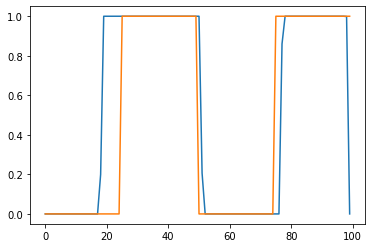

In [53]:
plt.plot(pstock_mean)
plt.plot(s)

In [ ]:
# --- Approximate Gaussian processes --- #
def approx_se_ncp(x, alpha, length, L, M):
    """
    Hilbert space approximation for the squared
    exponential kernel in the non-centered parametrisation.
    """
    phi = eigenfunctions(x, L, M)
    spd = jnp.sqrt(diag_spectral_density(alpha, length, L, M))
    with numpyro.plate("basis", M):
        beta = numpyro.sample("beta", dist.Normal(0, 1))

    f = numpyro.deterministic("f", phi @ (spd * beta))
    return f

In [ ]:
# --- Modelling utility functions --- #
def spectral_density(w, alpha, length):
    c = alpha * jnp.sqrt(2 * jnp.pi) * length
    e = jnp.exp(-0.5 * (length**2) * (w**2))
    return c * e


def diag_spectral_density(alpha, length, L, M):
    sqrt_eigenvalues = jnp.arange(1, 1 + M) * jnp.pi / 2 / L
    return spectral_density(sqrt_eigenvalues, alpha, length)


def eigenfunctions(x, L, M):
    """
    The first `M` eigenfunctions of the laplacian operator in `[-L, L]`
    evaluated at `x`. These are used for the approximation of the
    squared exponential kernel.
    """
    m1 = (jnp.pi / (2 * L)) * jnp.tile(L + x[:, None], M)
    m2 = jnp.diag(jnp.linspace(1, M, num=M))
    num = jnp.sin(m1 @ m2)
    den = jnp.sqrt(L)
    return num / den


def trend_gp(x, L, M):
    alpha = sample("alpha", dist.HalfNormal(1.0))
    length = sample("length", dist.InverseGamma(10.0, 2.0))
    f = approx_se_ncp(x, alpha, length, L, M)
    return f

def model()


    intercept = numpyro.sample("intercept", dist.Normal(0, 1))

    f = numpyro.deterministic("f", intercept + f1 + f2 + jnp.exp(g3) * weekday + day)
    sigma = numpyro.sample("sigma", dist.HalfNormal(0.5))
    with numpyro.plate("obs", x.shape[0]):
        numpyro.sample("y", dist.Normal(f, sigma), obs=y)


### Single product with stockout

In [4]:
N= 10000
lam = 1
t = jnp.arange(N)
td = np.subtract.outer(t, t)
d = rng.poisson(lam,N)
s = np.repeat([1,1,0,1,1], N/5)
x = d * s
i = np.where(x>0,1,0) # in-stock is known indicator
o = np.where(x==0,1,0) # in-stock not known indicator

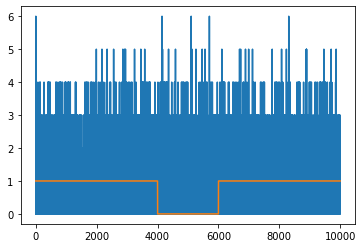

In [5]:
plt.plot(d)
plt.plot(s)

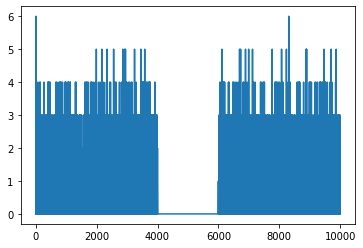

In [6]:
plt.plot(x)

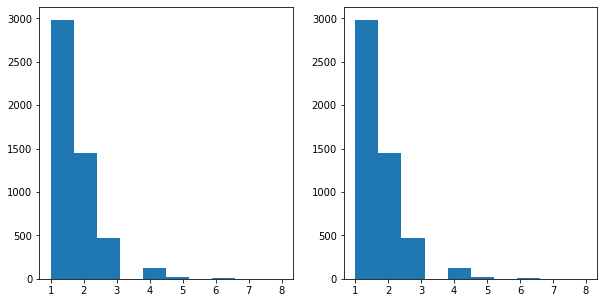

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
_ = ax[0].hist(x[i==1])
_ = ax[1].hist(d[i==1])

In [7]:
# Some averages
print('Mean demand: ', np.mean(d))
print('Mean sales: ', np.mean(x))
print('Mean sales:, given sales > 0 ', np.mean(x[i==1]))
print('Mean demand:, given sales > 0 ', np.mean(d[i==1]))
print('Mean demand:, given sales == 0 ', np.mean(d[o==1]))
print('Probability of being in stock ',np.mean(s) )
print('Probability of being in stock, given no sales ',np.mean(s[i==0]) )
print('Probability of being in stock, given sales ',np.mean(s[i==1]) )
print('Mean demand, given in stock ',np.mean(d[s==1]) )
print('Mean demand, given not in stock ',np.mean(d[s==0]) )


Mean demand:  0.98
Mean sales:  0.7833
Mean sales:, given sales > 0  1.5898112441648062
Mean demand:, given sales > 0  1.5898112441648062
Mean demand:, given sales == 0  0.387739010447467
Probability of being in stock  0.8
Probability of being in stock, given no sales  0.6057559629410605
Probability of being in stock, given sales  1.0
Mean demand, given in stock  0.979125
Mean demand, given not in stock  0.9835


#### Single probability of stockout

In [8]:
def model(t, x, i):

    # Get index postions of observations where instock indicator is missing
    num_nan = np.sum(o)
    #print(num_nan)

    # in stock model
    #beta_a = numpyro.sample('beta_a', dist.Exponential(0.1))
    #beta_b = numpyro.sample('beta_b', dist.Exponential(0.1))
    #p_instock = numpyro.sample('p_instock | instock missing', dist.Beta(beta_a, beta_b))#.expand([num_nan]))
    #print('shape of p_instock: ', p_instock.shape)
    p_instock = numpyro.sample('p_instock', dist.Beta(2, 2))
    numpyro.sample('instock | instock not missing', dist.BernoulliProbs(p_instock), obs=i[i==1] )

    # demand model
    alpha_demand = numpyro.sample('alpha_demand', dist.Normal(1,2))
    lam = jnp.exp(alpha_demand)

    # instock indicator is not missing
    obs = numpyro.sample('sales | instock not missing', dist.Poisson(lam), obs=x[i==1])

    # instock indicator is missing. if there was stock, then that means demAnd was zero
    custom_logprob = jnp.logaddexp(
        jnp.log(p_instock) + dist.Poisson(lam).log_prob(x[i==0]), # log probs of observing 0 sales, given in stock and demand rate lam
        jnp.log(1-p_instock) + 0 # probability of observing 0 sales when item is out of stock is 1, so log prob is 0
    )
    numpyro.factor("sales | instock missing", custom_logprob) # this just includes the custom logprob into the Numpyro model

m1 = MCMC(NUTS(model), num_warmup=1000, num_samples=5000, num_chains=1)
m1.run(random.PRNGKey(0), t=t, x=jnp.array(x), i=i)
m1.print_summary()


sample: 100%|██████████| 6000/6000 [00:32<00:00, 185.79it/s, 3 steps of size 5.14e-01. acc. prob=0.94] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha_demand      0.01      0.02      0.01     -0.02      0.04   1626.47      1.00
     p_instock      0.77      0.01      0.77      0.76      0.79   1637.58      1.00

Number of divergences: 0


1 1.0126934


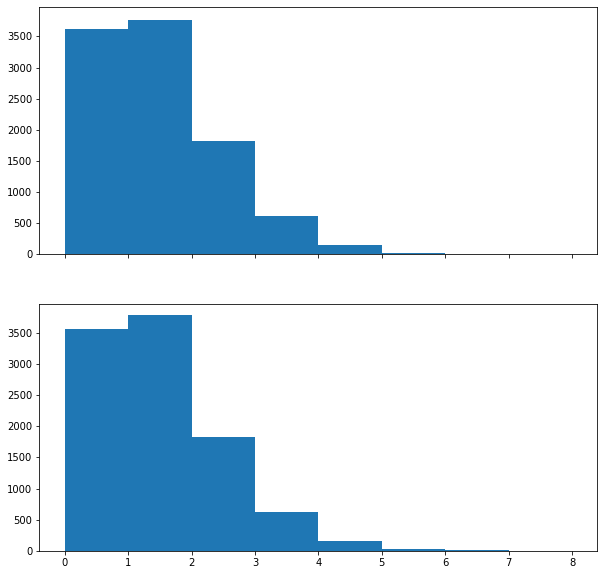

In [9]:
post = m1.get_samples()
lam_post = jnp.exp(post['alpha_demand'])
lam_mean = jnp.mean(lam_post)
fig, ax = plt.subplots(2,1,figsize=(10,10), sharex=True, sharey=True)
bins=range(9)
_ = ax[0].hist(rng.poisson(lam,10000), bins=bins)
_ = ax[1].hist(rng.poisson(lam_mean,10000), bins=bins)
print(lam, lam_mean)

In [29]:
def model(x):
    aps = numpyro.sample("alpha_prob_stockout", dist.Normal(0, 2))
    ad = numpyro.sample("alpha_demand", dist.Normal(1, 1))
    ps = numpyro.deterministic('prob_stockout', expit(aps))
    lam = jnp.exp(ad)
    numpyro.sample("obs", dist.ZeroInflatedPoisson(ps, lam), obs=x)

m1 = MCMC(NUTS(model), num_warmup=1000, num_samples=5000, num_chains=1)
m1.run(random.PRNGKey(0), x=x)
m1.print_summary()  

sample: 100%|██████████| 6000/6000 [00:09<00:00, 607.59it/s, 7 steps of size 6.06e-01. acc. prob=0.90] 



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
         alpha_demand     -0.01      0.02     -0.01     -0.04      0.02   1556.84      1.00
  alpha_prob_stockout     -1.43      0.07     -1.43     -1.55     -1.31   1471.90      1.00

Number of divergences: 0


1 0.98927116
0.19332486


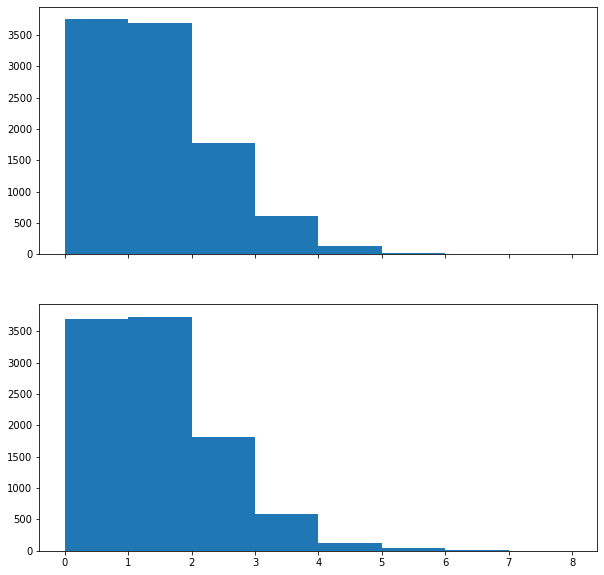

In [30]:
post = m1.get_samples()
lam_post = jnp.exp(post['alpha_demand'])
lam_mean = jnp.mean(lam_post)
fig, ax = plt.subplots(2,1,figsize=(10,10), sharex=True, sharey=True)
bins=range(9)
_ = ax[0].hist(rng.poisson(lam,10000), bins=bins)
_ = ax[1].hist(rng.poisson(lam_mean,10000), bins=bins)
print(lam, lam_mean)
print(post['prob_stockout'].mean())

#### Allow each day to have its own proability of stockout, samples from a common beta distribution

In [10]:
def model(t, x, i):

    num_obs = x.shape[0]

    # Get index postions of observations where instock indicator is missing
    num_nan = np.sum(o)
    #print(num_nan)

    # in stock model
    beta_a = numpyro.sample('beta_a', dist.Exponential(0.1))
    beta_b = numpyro.sample('beta_b', dist.Exponential(0.1))
    p_instock = numpyro.sample('p_instock', dist.Beta(beta_a, beta_b).expand([num_obs]))
    #print('shape of p_instock: ', p_instock.shape)
    #p_instock = numpyro.sample('p_instock', dist.Beta(2, 2))
    numpyro.sample('p(instock) | sales > 0', dist.BernoulliProbs(p_instock[i==1]), obs=i[i==1] )

    # demand model
    alpha_demand = numpyro.sample('alpha_demand', dist.Normal(1,2))
    lam = jnp.exp(alpha_demand)

    # instock indicator is not missing
    obs = numpyro.sample('sales | instock not missing', dist.Poisson(lam), obs=x[i==1])

    # instock indicator is missing. if there was stock, then that means demAnd was zero
    custom_logprob = jnp.logaddexp(
        jnp.log(p_instock[i==0]) + dist.Poisson(lam).log_prob(x[i==0]), # log probs of observing 0 sales, given in stock and demand rate lam
        jnp.log(1-p_instock[i==0]) + 0 # probability of observing 0 sales when item is out of stock is 1, so log prob is 0
    )
    numpyro.factor("sales | instock missing", custom_logprob) # this just includes the custom logprob into the Numpyro model

m1 = MCMC(NUTS(model), num_warmup=100, num_samples=500, num_chains=1)
m1.run(random.PRNGKey(0), t=t, x=jnp.array(x), i=i)
m1.print_summary()

sample: 100%|██████████| 600/600 [02:20<00:00,  4.27it/s, 127 steps of size 3.94e-02. acc. prob=0.94]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_demand      0.01      0.02      0.01     -0.02      0.03     67.60      1.01
         beta_a      5.92      1.15      5.82      3.88      7.73      5.41      1.06
         beta_b      1.71      0.29      1.67      1.27      2.27      5.24      1.06
   p_instock[0]      0.75      0.15      0.77      0.52      0.96   1005.55      1.00
   p_instock[1]      0.80      0.14      0.83      0.61      1.00    776.65      1.00
   p_instock[2]      0.81      0.12      0.84      0.64      0.99    746.59      1.00
   p_instock[3]      0.75      0.14      0.77      0.55      0.99    734.53      1.00
   p_instock[4]      0.81      0.12      0.83      0.64      0.99    671.28      1.00
   p_instock[5]      0.80      0.12      0.82      0.62      0.98    656.68      1.00
   p_instock[6]      0.75      0.14      0.76      0.53      0.97    573.36      1.00
   p_instock[7]      0.74      0.15      0.77      0.

1 1.0113305


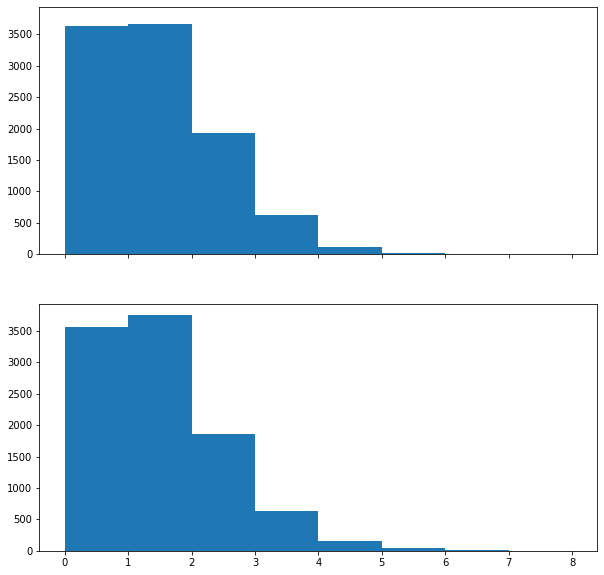

In [11]:
# Look at demand
post = m1.get_samples()
lam_post = jnp.exp(post['alpha_demand'])
lam_mean = jnp.mean(lam_post)
fig, ax = plt.subplots(2,1,figsize=(10,10), sharex=True, sharey=True)
bins=range(9)
_ = ax[0].hist(rng.poisson(lam,10000), bins=bins)
_ = ax[1].hist(rng.poisson(lam_mean,10000), bins=bins)
print(lam, lam_mean)

Mean p_instock:  0.77201366


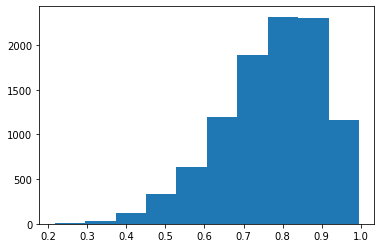

In [19]:
# Stockout
p_instock = post['p_instock'][-1,]
print('Mean p_instock: ', jnp.mean(p_instock))
_ = plt.hist(p_instock)


In [21]:
post.keys()

dict_keys(['alpha_demand', 'beta_a', 'beta_b', 'p_instock'])

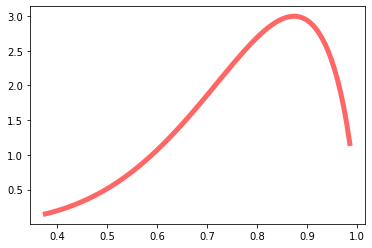

In [22]:
a, b = post['beta_a'].mean(), post['beta_b'].mean()
x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
plt.plot(x, beta.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='beta pdf')

### Now two products simultaneously, but no substitution yet

In [27]:
N= 1000
lam_a = 2
lam_b = 1
t = jnp.arange(N)
td = np.subtract.outer(t, t)
d_a = rng.poisson(lam_a,N)
d_b = rng.poisson(lam_b,N)
s_a = np.repeat([1,1,0,1,1], N/5)
s_b = np.repeat([1,1,1,0,0], N/5)
x_a = d_a * s_a
x_b = d_b * s_b
i_a = np.where(x_a>0,1,0) # in-stock is known indicator
i_b = np.where(x_b>0,1,0) # in-stock is known indicator

#o = np.where(x==0,1,0) # in-stock not known indicator

In [42]:
# Some averages
print('Mean demand a: ', np.mean(d_a))
print('Mean demand b: ', np.mean(d_b))
print('Probability of a being in stock ',np.mean(s_a) )
print('Probability of b being in stock ',np.mean(s_b) )


Mean demand a:  2.079
Mean demand b:  0.98
Probability of a being in stock  0.8
Probability of b being in stock  0.6


In [33]:
def model(t, x_a, i_a, x_b, i_b):

    num_obs = t.shape[0]

    # Get index postions of observations where instock indicator is missing
    num_nan = np.sum(o)
    #print(num_nan)

    # Models for Product A

    # There were some sales in the period
    # instock model
    A_beta_a = numpyro.sample('A_beta_a', dist.Exponential(0.1))
    A_beta_b = numpyro.sample('A_beta_b', dist.Exponential(0.1))
    A_p_instock = numpyro.sample('A_p_instock', dist.Beta(A_beta_a, A_beta_b).expand([num_obs]))
    numpyro.sample('p(A_instock) | A_sales > 0', dist.BernoulliProbs(A_p_instock[i_a==1]), obs=i_a[i_a==1] )

    # demand model
    A_alpha_demand = numpyro.sample('A_alpha_demand', dist.Normal(1,2))
    A_lam = jnp.exp(A_alpha_demand)
    A_obs = numpyro.sample('A demand | A sales > 0', dist.Poisson(A_lam), obs=x_a[i_a==1])

    # There we no sales. If there was stock, then that means demand was zero
    A_custom_logprob = jnp.logaddexp(
        jnp.log(A_p_instock[i_a==0]) + dist.Poisson(A_lam).log_prob(x_a[i_a==0]), # log probs of observing 0 sales, given in stock and demand rate lam
        jnp.log(1-A_p_instock[i_a==0]) + 0 # probability of observing 0 sales when item is out of stock is 1, so log prob is 0
    )
    numpyro.factor("A demand | A sales = 0", A_custom_logprob) # this just includes the custom logprob into the Numpyro model

    # Models for Product B

    # There were some sales in the period
    # instock model
    B_beta_a = numpyro.sample('B_beta_a', dist.Exponential(0.1))
    B_beta_b = numpyro.sample('B_beta_b', dist.Exponential(0.1))
    B_p_instock = numpyro.sample('B_p_instock', dist.Beta(B_beta_a, B_beta_b).expand([num_obs]))
    numpyro.sample('p(B_instock) | B_sales > 0', dist.BernoulliProbs(B_p_instock[i_b==1]), obs=i_b[i_b==1] )

    # demand model
    B_alpha_demand = numpyro.sample('B_alpha_demand', dist.Normal(1,2))
    B_lam = jnp.exp(B_alpha_demand)
    B_obs = numpyro.sample('B demand | B sales > 0', dist.Poisson(B_lam), obs=x_b[i_b==1])

    # There we no sales. If there was stock, then that means demand was zero
    B_custom_logprob = jnp.logaddexp(
        jnp.log(B_p_instock[i_b==0]) + dist.Poisson(B_lam).log_prob(x_b[i_b==0]), # log probs of observing 0 sales, given in stock and demand rate lam
        jnp.log(1-B_p_instock[i_b==0]) + 0 # probability of observing 0 sales when item is out of stock is 1, so log prob is 0
    )
    numpyro.factor("B demand | B sales = 0", B_custom_logprob) # this just includes the custom logprob into the Numpyro model


m1 = MCMC(NUTS(model), num_warmup=100, num_samples=500, num_chains=1)
m1.run(random.PRNGKey(0), t=t, x_a=jnp.array(x_a), i_a=i_a, x_b=jnp.array(x_b), i_b=i_b)
m1.print_summary()

sample: 100%|██████████| 600/600 [00:15<00:00, 38.04it/s, 31 steps of size 1.08e-01. acc. prob=0.88] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
  A_alpha_demand      0.71      0.03      0.71      0.65      0.75     88.68      1.00
        A_beta_a      7.49      2.87      6.82      4.03     12.03     11.35      1.18
        A_beta_b      1.71      0.49      1.63      0.96      2.46     10.33      1.20
  A_p_instock[0]      0.75      0.14      0.78      0.53      0.95    403.36      1.00
  A_p_instock[1]      0.83      0.12      0.85      0.67      1.00    503.95      1.00
  A_p_instock[2]      0.83      0.11      0.86      0.70      1.00    956.37      1.00
  A_p_instock[3]      0.83      0.11      0.86      0.66      0.99    811.68      1.00
  A_p_instock[4]      0.84      0.11      0.87      0.69      0.99    707.96      1.00
  A_p_instock[5]      0.76      0.14      0.79      0.56      0.99    382.41      1.00
  A_p_instock[6]      0.83      0.12      0.85      0.65      1.00    599.73      1.00
  A_p_instock[7]      0.84      0.11      

Product A input and estimated rate of demand:  2 2.0354698
Product B input and estimated rate of demand:  1 1.0900444


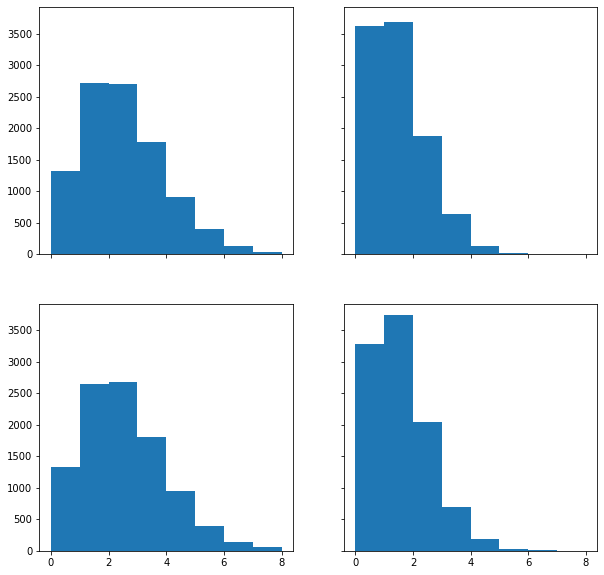

In [35]:
# Look at demand
post = m1.get_samples()
lam_post_a = jnp.exp(post['A_alpha_demand'])
lam_mean_a = jnp.mean(lam_post_a)
lam_post_b = jnp.exp(post['B_alpha_demand'])
lam_mean_b = jnp.mean(lam_post_b)
fig, ax = plt.subplots(2,2,figsize=(10,10), sharex=True, sharey=True)
bins=range(9)
# product A
_ = ax[0,0].hist(rng.poisson(lam_a,10000), bins=bins)
_ = ax[1,0].hist(rng.poisson(lam_mean_a,10000), bins=bins)
# product A
_ = ax[0,1].hist(rng.poisson(lam_b,10000), bins=bins)
_ = ax[1,1].hist(rng.poisson(lam_mean_b,10000), bins=bins)
print('Product A input and estimated rate of demand: ', lam_a, lam_mean_a)
print('Product B input and estimated rate of demand: ', lam_b, lam_mean_b)

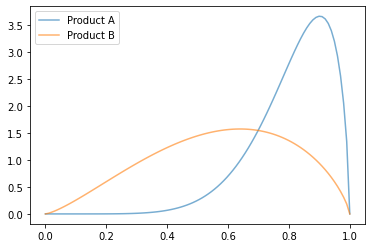

In [41]:
A_a, A_b = post['A_beta_a'].mean(), post['A_beta_b'].mean()
B_a, B_b = post['B_beta_a'].mean(), post['B_beta_b'].mean()
x = np.linspace(0,1,100)
plt.plot(x, beta.pdf(x, A_a, A_b), alpha=0.6, label='Product A')
plt.plot(x, beta.pdf(x, B_a, B_b), alpha=0.6, label='Product B')
plt.legend()

### Now model that, when Product A is out of stock, some proportion of that demand is transferred to Product B

In [10]:
N= 1000
lam_a = 2
lam_b = 1
t = jnp.arange(N)
td = np.subtract.outer(t, t)
d_a = rng.poisson(lam_a,N)
d_b = rng.poisson(lam_b,N)
s_a = np.repeat([1,1,1,0,0], N/5)
s_b = np.repeat([1,1,1,1,0], N/5)
# new bit
p_a_b = 0.5 # proportion of demand for product A which is trnasferred to product B, when A is out of stock
d_a_b = rng.binomial(d_a,p_a_b*(1-s_a))

x_a = d_a * s_a
x_b = ( d_b + d_a_b ) * s_b
i_a = np.where(x_a>0,1,0) # in-stock is known indicator
i_b = np.where(x_b>0,1,0) # in-stock is known indicator

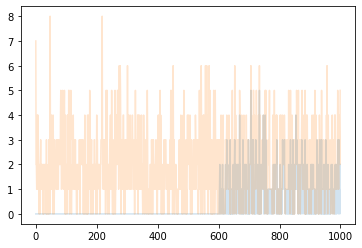

In [11]:
# Check subsitution of B for A when A out of stock
plt.plot(d_a_b, alpha=0.2)
plt.plot(d_a, alpha=0.2)

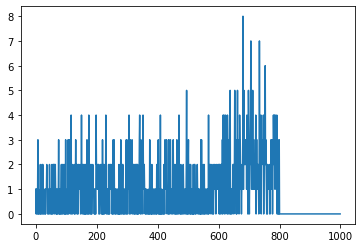

In [12]:
plt.plot(x_b)

In [13]:
# Some averages
print('Mean demand a: ', np.mean(d_a))
print('Mean demand b: ', np.mean(d_b))
print('Probability of a being in stock ',np.mean(s_a) )
print('Probability of b being in stock ',np.mean(s_b) )


Mean demand a:  1.958
Mean demand b:  0.96
Probability of a being in stock  0.6
Probability of b being in stock  0.8


In [85]:
def stock_sub_poisson(lam, lam_with_sub, in_stock, other_in_stock, sales):
    # Get log prob of observing sales, given other parameters
    eps = 1e-10
    #print('args: ', lam, lam_with_sub, in_stock, other_in_stock, sales.shape)

    if not in_stock:
        # case where not in stock...so zero sales have prob 1 and other sales have prob 0
        # logprob = jnp.sum(dist.Poisson(eps).log_prob(sales))
        logprob = jnp.sum(jnp.log(jnp.where(sales==0,1,eps)))
    
    elif other_in_stock:
        # case where is in stock, and so it other product
        logprob = jnp.sum(dist.Poisson(lam).log_prob(sales))

    elif not other_in_stock:
        # case where is in stock, but other is out of stock
        logprob = jnp.sum(dist.Poisson(lam_with_sub).log_prob(sales))

    else:
        logprob = 0

    #print('logbprob: ', logprob)
    return logprob


In [86]:
def model(t, x_a, i_a, x_b):

    # Models for Product A

    # There were some sales in the period
    # instock model
    A_p_instock = numpyro.sample('A_p_instock', dist.Beta(2,2))
    numpyro.sample('p(A_instock) | A_sales > 0', dist.BernoulliProbs(A_p_instock), obs=i_a[i_a==1] )

    # demand model
    A_alpha_demand = numpyro.sample('A_alpha_demand', dist.Normal(0,2))
    A_lam = jnp.exp(A_alpha_demand)
    A_obs = numpyro.sample('A demand | A sales > 0', dist.Poisson(A_lam), obs=x_a[i_a==1])

    # There we no sales. If there was stock, then that means demand was zero
    A_custom_logprob = jnp.logaddexp(
        jnp.log(A_p_instock) + dist.Poisson(A_lam).log_prob(x_a[i_a==0]), # log probs of observing 0 sales, given in stock and demand rate lam
        jnp.log(1-A_p_instock) + 0 # probability of observing 0 sales when item is out of stock is 1, so log prob is 0
    )
    numpyro.factor("A demand | A sales = 0", A_custom_logprob) # this just includes the custom logprob into the Numpyro model

    # Models for Product B

    # There were some sales in the period
    # instock model
    B_p_instock = numpyro.sample('B_p_instock', dist.Beta(2,2))

    # demand model
    B_alpha_demand = numpyro.sample('B_alpha_demand', dist.Normal(0,2))
    B_lam = jnp.exp(B_alpha_demand)

    # customers substituting B instead of A, when A is out of stock
    p_subs_a_b = numpyro.sample('Prop demand A to B | A out of stock', dist.Beta(2,2))
    A_B_lam = A_lam * p_subs_a_b
    B_A_lam = B_lam + A_B_lam # Total rate of demand for B, when A is out of stock

    # Log prob of observing the sales of B, averaging over the combination of A and B being in and out of stock
    logprob_A_and_B = jnp.log(A_p_instock) + jnp.log(B_p_instock) + stock_sub_poisson(B_lam, B_A_lam, True, True, x_b)
    logprob_A_not_B = jnp.log(A_p_instock) + jnp.log(1-B_p_instock) + stock_sub_poisson(B_lam, B_A_lam, True, False, x_b)
    logprob_not_A_and_B = jnp.log(1-A_p_instock) + jnp.log(B_p_instock) + stock_sub_poisson(B_lam, B_A_lam, False, True, x_b)
    logprob_not_A_not_B = jnp.log(1-A_p_instock) + jnp.log(1-B_p_instock) + stock_sub_poisson(B_lam, B_A_lam, False, False, x_b)

    log_prob_B_sales = jnp.logaddexp(jnp.logaddexp(logprob_A_and_B, logprob_A_not_B), jnp.logaddexp(logprob_not_A_and_B, logprob_not_A_not_B))

    numpyro.factor("p(sales of B | demand and stock of A and B)", log_prob_B_sales) # this just includes the custom logprob into the Numpyro model 

m1 = MCMC(NUTS(model), num_warmup=1000, num_samples=5000, num_chains=1)
m1.run(random.PRNGKey(0), t=t, x_a=jnp.array(x_a), i_a=i_a, x_b=jnp.array(x_b))
m1.print_summary()

sample: 100%|██████████| 6000/6000 [00:12<00:00, 486.27it/s, 7 steps of size 4.96e-01. acc. prob=0.90] 



                                           mean       std    median      5.0%     95.0%     n_eff     r_hat
                       A_alpha_demand      0.70      0.04      0.70      0.64      0.76   2100.10      1.00
                          A_p_instock      0.58      0.02      0.58      0.55      0.61   3582.97      1.00
                       B_alpha_demand     -0.07      0.04     -0.07     -0.12     -0.01    271.19      1.00
                          B_p_instock      0.60      0.20      0.61      0.27      0.92   5226.23      1.00
  Prop demand A to B | A out of stock      0.49      0.23      0.49      0.13      0.88   1435.28      1.00

Number of divergences: 0


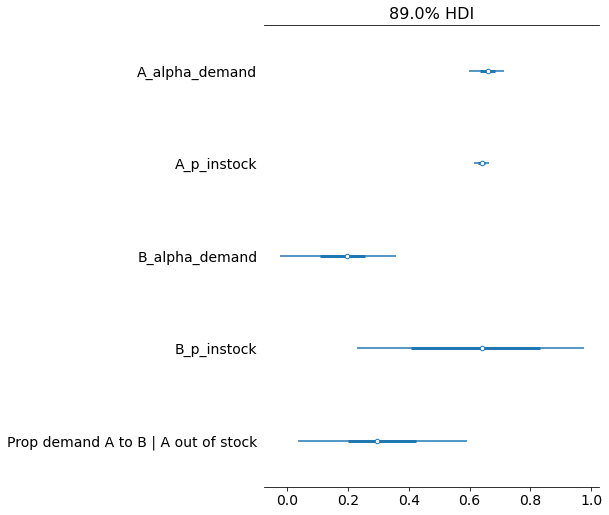

In [88]:
_ = az.plot_forest(post,hdi_prob=0.89)

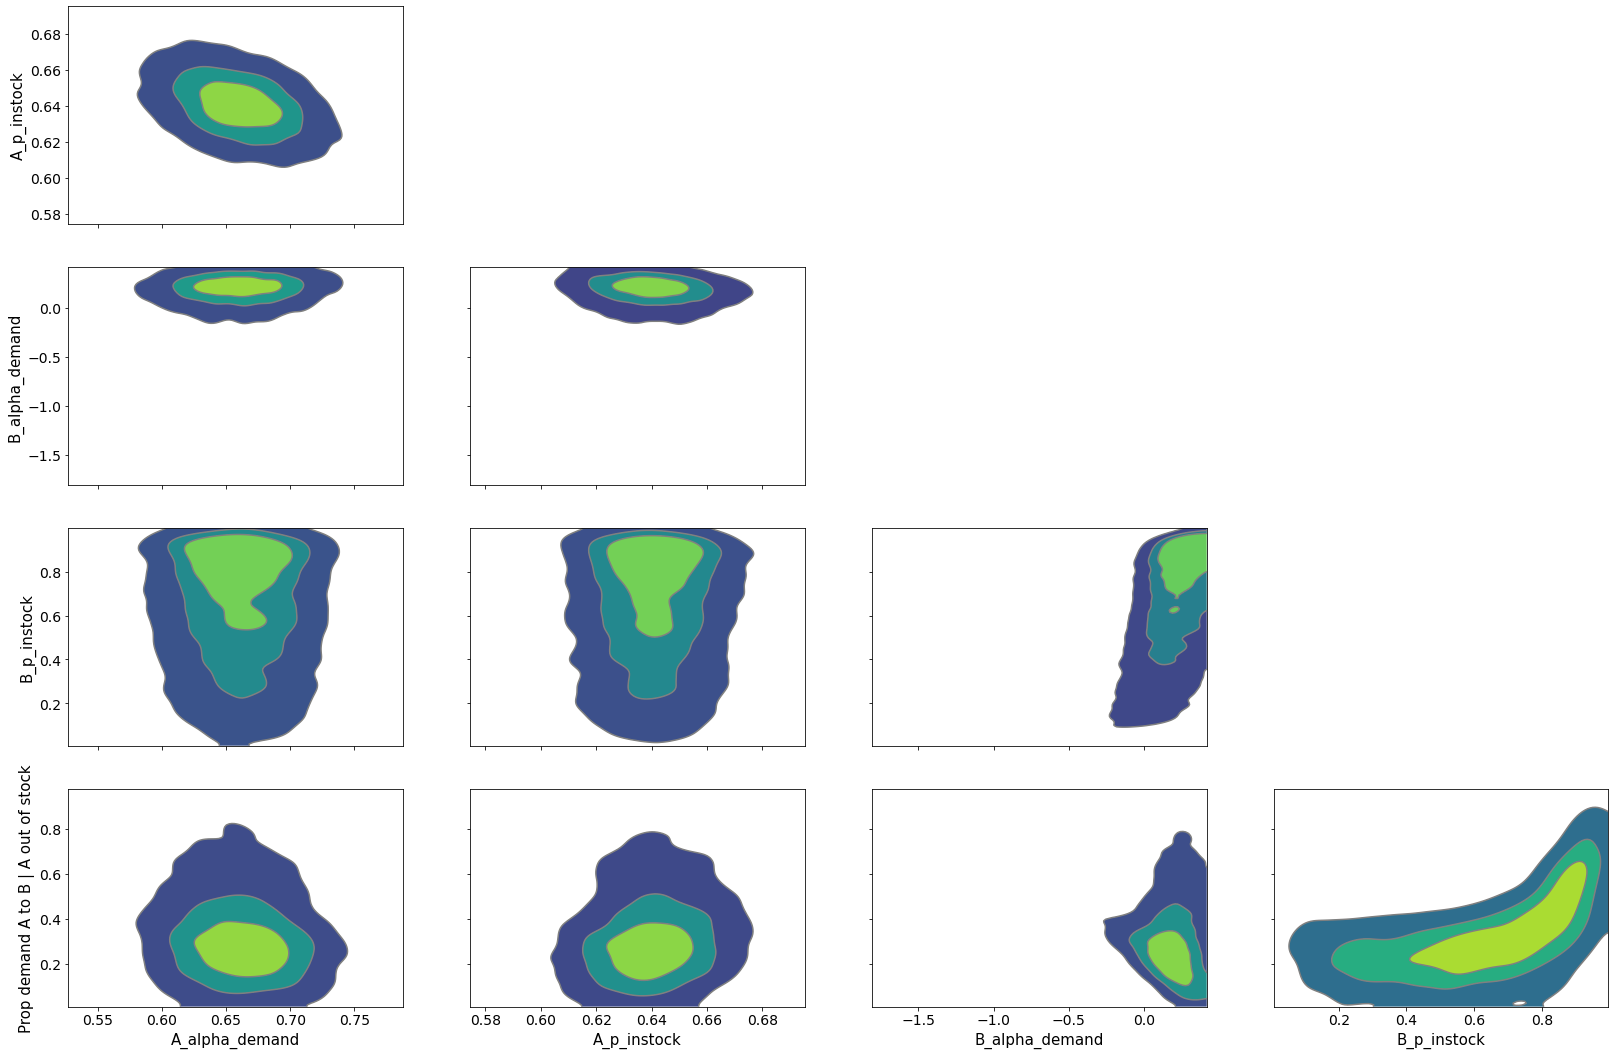

In [89]:
_ = az.plot_pair(post,kind="kde",kde_kwargs={"hdi_probs": [0.3, 0.6, 0.9]})

Product A input and estimated rate of demand:  1.9580001 2.0113156
Product B input and estimated rate of demand:  0.96000004 0.9336418


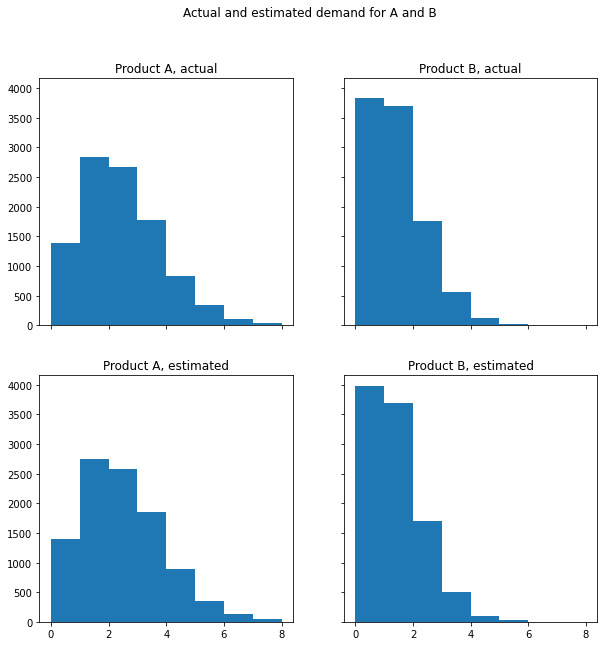

In [90]:
# Look at demand
post = m1.get_samples()
lam_post_a = jnp.exp(post['A_alpha_demand'])
lam_mean_a = jnp.mean(lam_post_a)
lam_post_b = jnp.exp(post['B_alpha_demand'])
lam_mean_b = jnp.mean(lam_post_b)
fig, ax = plt.subplots(2,2,figsize=(10,10), sharex=True, sharey=True)
bins=range(9)
# product A
_ = ax[0,0].hist(rng.poisson(jnp.mean(d_a),10000), bins=bins)
ax[0,0].set_title('Product A, actual')
_ = ax[1,0].hist(rng.poisson(lam_mean_a,10000), bins=bins)
ax[1,0].set_title('Product A, estimated')
# product B
_ = ax[0,1].hist(rng.poisson(jnp.mean(d_b),10000), bins=bins)
ax[0,1].set_title('Product B, actual')
_ = ax[1,1].hist(rng.poisson(lam_mean_b,10000), bins=bins)
ax[1,1].set_title('Product B, estimated')
fig.suptitle('Actual and estimated demand for A and B')
print('Product A input and estimated rate of demand: ', jnp.mean(d_a), lam_mean_a)
print('Product B input and estimated rate of demand: ', jnp.mean(d_b), lam_mean_b)

In [112]:
# Look at stockouts and substitution
print(f"Proportion of A's demand transferred to B when A is out of stock.  Actual: {p_a_b:.0%}, Estimated: {jnp.mean(post['Prop demand A to B | A out of stock']):.0%}")
print(f"Proportion of periods in which A is out of stock.  Actual: {jnp.mean(1-s_a):.0%}, Estimated: {jnp.mean(1-post['A_p_instock']):.0%}")
print(f"Proportion of periods in which B is out of stock.  Actual: {jnp.mean(1-s_b):.0%}, Estimated: {jnp.mean(1-post['B_p_instock']):.0%}")
print(f"Location of estimated proportion of periods in which B is out of stock.  Mean: {jnp.mean(1-post['B_p_instock']):.0%}, Mode: {stats.mode(1-post['B_p_instock'])[0].item(0):.0%}, Median: {jnp.median(1-post['B_p_instock']):.0%}")



Proportion of A's demand transferred to B when A is out of stock.  Actual: 50%, Estimated: 49%
Proportion of periods in which A is out of stock.  Actual: 40%, Estimated: 42%
Proportion of periods in which B is out of stock.  Actual: 20%, Estimated: 40%
Location of estimated proportion of periods in which B is out of stock.  Mean: 40%, Mode: 53%, Median: 39%
